# Modelling

In [1]:
from scipy.spatial import distance
from sklearn import manifold
from sklearn import decomposition
from sklearn import preprocessing
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import KMeans
from sklearn import svm
from sklearn import ensemble
from sklearn import model_selection as ms
from sklearn import neighbors
from sklearn.metrics import mean_squared_error

# rdkit mols are displayed as images
from rdkit.Chem.Draw import IPythonConsole

from rdkit.Chem import AllChem as Chem
from rdkit import DataStructs
from rdkit.Chem.SaltRemover import SaltRemover

# descriptors
from rdkit.Chem import Lipinski
from rdkit.Chem import rdMolDescriptors
from rdkit.Chem import Descriptors

# plots
from matplotlib import pyplot
import seaborn

# other packages
import pandas as pd
import numpy as np
import csv
import re

Remove salts for standardization:

In [2]:
sr = SaltRemover() # from rdkit
m = Chem.MolFromSmiles("[Na+].C(=O)[O-]")
print(Chem.MolToSmiles(sr(m)))

O=C[O-]


In [3]:
""" contribution from Hans de Winter """
def _InitialiseNeutralisationReactions():
    patts= (
        # Imidazoles
        ('[n+;H]','n'),
        # Amines
        ('[N+;!H0]','N'),
        # Carboxylic acids and alcohols
        ('[$([O-]);!$([O-][#7])]','O'),
        # Thiols
        ('[S-;X1]','S'),
        # Sulfonamides
        ('[$([N-;X2]S(=O)=O)]','N'),
        # Enamines
        ('[$([N-;X2][C,N]=C)]','N'),
        # Tetrazoles
        ('[n-]','[nH]'),
        # Sulfoxides
        ('[$([S-]=O)]','S'),
        # Amides
        ('[$([N-]C=O)]','N'),
        )
    return [(Chem.MolFromSmarts(x),Chem.MolFromSmiles(y,False)) for x,y in patts]

_reactions=None
def NeutraliseCharges(mol, reactions=None):
    global _reactions
    if reactions is None:
        if _reactions is None:
            _reactions=_InitialiseNeutralisationReactions()
        reactions=_reactions
    replaced = False
    for i,(reactant, product) in enumerate(reactions):
        while mol.HasSubstructMatch(reactant):
            replaced = True
            rms = Chem.ReplaceSubstructs(mol, reactant, product)
            mol = rms[0]
    return mol, replaced

In [4]:
smis=("c1cccc[nH+]1",
      "C[N+](C)(C)C","c1ccccc1[NH3+]",
      "CC(=O)[O-]","c1ccccc1[O-]",
      "CCS",
      "C[N-]S(=O)(=O)C",
      "C[N-]C=C","C[N-]N=C",
      "c1ccc[n-]1",
      "CC[N-]C(=O)CC")
for smi in smis:
    (molSmiles, neutralised) = NeutraliseCharges(Chem.MolFromSmiles(smi))
    print(smi + "->" + Chem.MolToSmiles(molSmiles))

c1cccc[nH+]1->c1ccncc1
C[N+](C)(C)C->C[N+](C)(C)C
c1ccccc1[NH3+]->Nc1ccccc1
CC(=O)[O-]->CC(=O)O
c1ccccc1[O-]->Oc1ccccc1
CCS->CCS
C[N-]S(=O)(=O)C->CNS(C)(=O)=O
C[N-]C=C->C=CNC
C[N-]N=C->C=NNC
c1ccc[n-]1->c1cc[nH]c1
CC[N-]C(=O)CC->CCNC(=O)CC


In [5]:
_saltRemover = SaltRemover()
_inorganicPatt = Chem.MolFromSmarts("[!#6;!#7;!#8;!#16;!F;!Cl;!Br;!I]") # to remove compounds with unwanted atom types
_carbonPatt = Chem.MolFromSmarts("[#6]") # to remove compounds without carbon - inorganic
def standardize(mol):
    if mol.HasSubstructMatch(_carbonPatt):
        mol = _saltRemover(mol)
        if mol.GetNumAtoms()==0:
            return None
        else:
            mol, neutralized = NeutraliseCharges(mol)
            if mol.HasSubstructMatch(_inorganicPatt):
                return None
            else:
                # Sanitize mol, without sanitization some structures can't be drawn or fingerprinted
                Chem.SanitizeMol(mol) # add catch block?
                return mol
    else:
        return None

## Load data

In [6]:
float_pattern = re.compile("[0-9]+(\.[0-9]*)?")
lip_func = [("HBA", Lipinski.NumHAcceptors), 
            ("HBD", Lipinski.NumHDonors), 
            ("MW", Descriptors.ExactMolWt),
            ("LogP", Descriptors.MolLogP), 
            ("TPSA", rdMolDescriptors.CalcTPSA), 
            ("RB", Lipinski.NumRotatableBonds)]

In [7]:
with open('./data/DOWNLOAD-ligands_for_serotonine_rec.csv', 'r') as csvfile:
    serotonine_ligands = [row for row in csv.DictReader(csvfile, delimiter=";", quotechar='"')]
    for m in serotonine_ligands:
        mol = Chem.MolFromSmiles(m["Smiles"])
        if mol:
            m["rdmol"] = mol
            stdmol = standardize(mol)
            m["source"] = "serotonine"
            m["pChEMBL Value"] = float(m["pChEMBL Value"]) if float_pattern.match(m["pChEMBL Value"]) else np.NaN
            m["std_rdmol"] = None
            m["Standard Value"] = float(m["Standard Value"]) if float_pattern.match(m["Standard Value"]) else np.NaN
        if stdmol:
            m["std_rdmol"] = stdmol
            m["std_smiles"] = Chem.MolToSmiles(stdmol)
            m["fps"] = Chem.GetMorganFingerprintAsBitVect(m["std_rdmol"],2,nBits=1024)
            for f in lip_func:
                m[f[0]] = f[1](m["std_rdmol"])

In [8]:
%%capture
# %%capture hides stderr (and maybe all output)
# same for drugbank
drugbank = []
for m in Chem.SDMolSupplier("../data/drugbank.sdf"):
    if m:
        stdmol = standardize(m)
    else:
        continue    
    if stdmol:
        std_smiles = Chem.MolToSmiles(stdmol)
        drugbank.append({
         "rdmol": m,
         "std_rdmol": stdmol,
         "source": "drugbank",
         "std_smiles": std_smiles,
         "Smiles": Chem.MolToSmiles(m),
         "pChEMBL Value": np.NaN,
         "Standard Value": np.NaN,
         "fps": Chem.GetMorganFingerprintAsBitVect(stdmol, 2, nBits=1024),
         **{f[0]: f[1](stdmol) for f in lip_func}
        })

In [40]:
# let's work with Pandas dataframe
df = pd.DataFrame((*drugbank, *[m for m in serotonine_ligands if m["std_rdmol"]]), columns=["Smiles", "std_smiles", "source", "rdmol", "std_rdmol", "fps", "Standard Value", "pChEMBL Value", *(f[0] for f in lip_func)])
# adds index as normal column
df.reset_index(level=0, inplace=True)
df = df.join(pd.DataFrame((rdMolDescriptors.MQNs_(mol) for mol in df["std_rdmol"]),
                          columns=[*(f"MQN_{x}" for x in range(1,43))])
            )

In [44]:
# Only use serotonine receptor ligands, which have specified Standard Value

df_serotonine = pd.DataFrame([*[m for m in serotonine_ligands if m["std_rdmol"]]], columns=["Smiles", "std_smiles", "source", "rdmol", "std_rdmol", "fps", "Standard Value", "pChEMBL Value", *(f[0] for f in lip_func)])
df_serotonine.dropna(axis=0, inplace=True)
df_serotonine.reset_index(level=0, inplace=True)

df_serotonine = df_serotonine.join(pd.DataFrame((rdMolDescriptors.MQNs_(mol) for mol in df["std_rdmol"]),
                          columns=[*(f"MQN_{x}" for x in range(1,43))])
            )

In [10]:
mx = df["Standard Value"].max()+1
#df["Standard Value"] = df["Standard Value"].fillna(mx+1)

# Some experiments

In [45]:
svr = svm.SVR()
svr.fit(df_serotonine[(f"MQN_{x}" for x in range(1, 43))], df_serotonine["Standard Value"])

SVR()

In [48]:
res = pd.DataFrame(svr.predict(df_serotonine[(f"MQN_{x}" for x in range(1, 43))])).join(df_serotonine[["Standard Value", "source"]])
res.columns = ["Prediction", "Standard Value", "Source"]
(res["Prediction"]-res["Standard Value"]).abs().mean()

2550.0726707898593

In [49]:
(res[res["Source"]=="serotonine"]["Prediction"]-res[res["Source"]=="serotonine"]["Standard Value"]).abs().mean()

2550.0726707898593

## Results from model

In [50]:
def get_results(model, data, descriptors, predicted_value):
    res = pd.DataFrame(model.predict(data[descriptors])).join(data[[predicted_value, "source"]])
    res.columns = ["Prediction", predicted_value, "Source"]
    print(f"""Average error whole set: {(res["Prediction"]-res[predicted_value]).abs().mean()}
Average error serotonine: {(res[res["Source"]=="serotonine"]["Prediction"]-res[res["Source"]=="serotonine"][predicted_value]).abs().mean()}""")
    return res

## SVR

In [51]:
res = get_results(svr, df_serotonine, (f"MQN_{x}" for x in range(1, 43)), "Standard Value")

Average error whole set: 2550.0726707898593
Average error serotonine: 2550.0726707898593


In [36]:
r = pd.DataFrame(svr.predict(df_valid[(f"MQN_{x}" for x in range(1, 43))]))

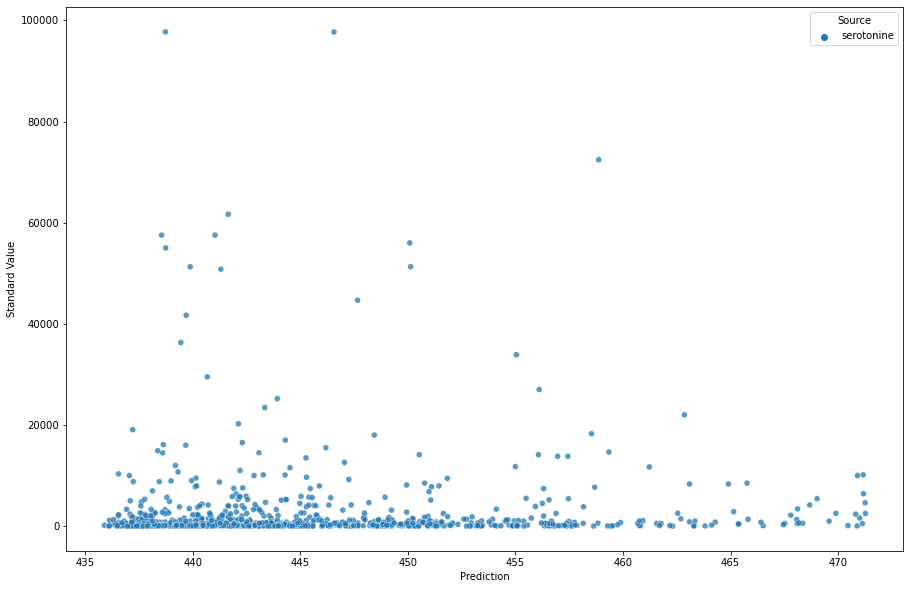

In [53]:
fig, ax = pyplot.subplots(figsize=(15,10))
p=seaborn.scatterplot(x="Prediction",
                      y="Standard Value",
                      data=res,
                      hue="Source",
                      legend="brief",
                      ax=ax,
                      alpha=0.75
                     )

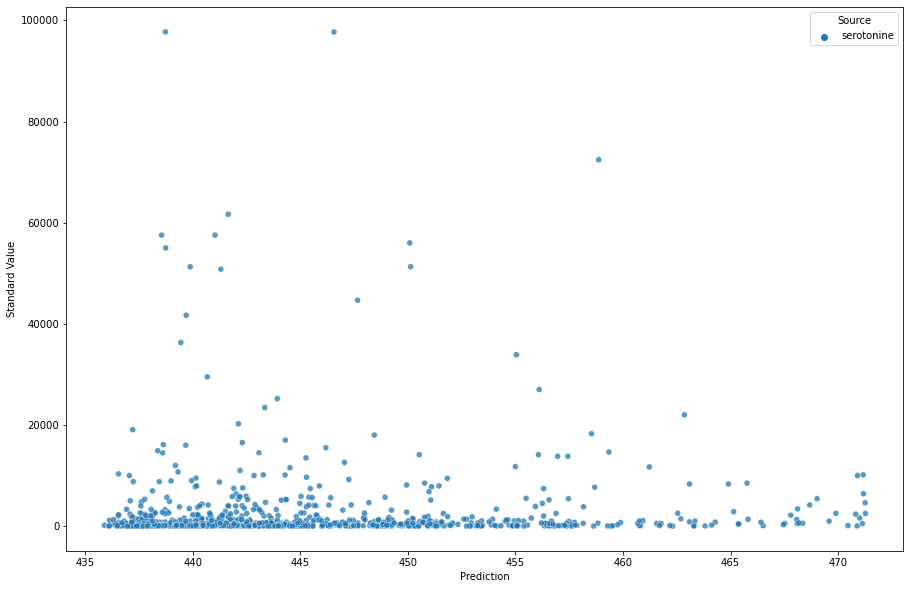

In [54]:
fig, ax = pyplot.subplots(figsize=(15,10))
p=seaborn.scatterplot(x="Prediction",
                      y="Standard Value",
                      data=res[res["Standard Value"]<mx],
                      hue="Source",
                      legend="brief",
                      ax=ax,
                      alpha=0.75
                     )

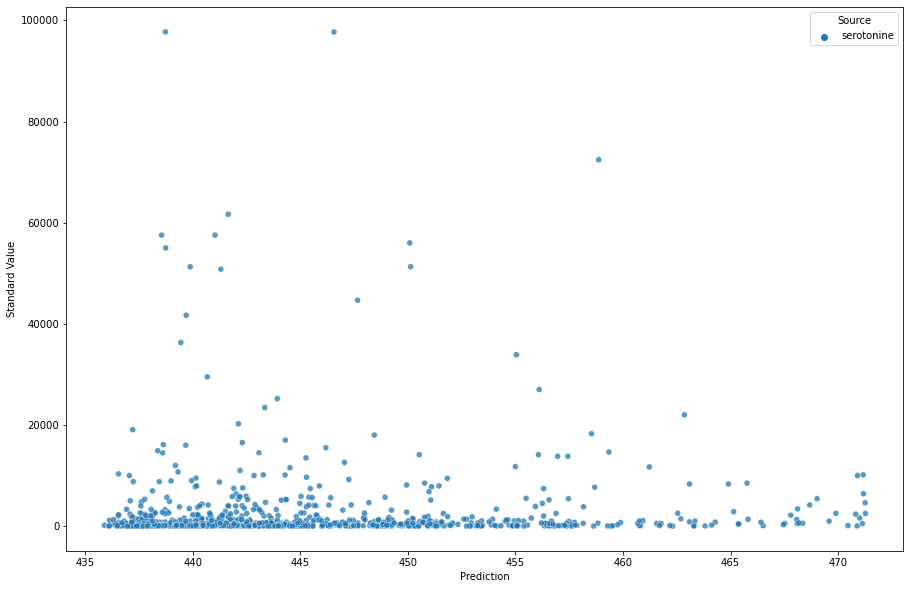

In [55]:
fig, ax = pyplot.subplots(figsize=(15,10))
p=seaborn.scatterplot(x="Prediction",
                      y="Standard Value",
                      data=res[res["Standard Value"]<mx/1000],
                      hue="Source",
                      legend="brief",
                      ax=ax,
                      alpha=0.75
                     )

## Random Forest

In [56]:
rf = ensemble.RandomForestRegressor()
rf.fit(df_serotonine[(f"MQN_{x}" for x in range(1, 43))], df_serotonine["Standard Value"])

RandomForestRegressor()

In [57]:
res_rf = get_results(rf, df_serotonine, (f"MQN_{x}" for x in range(1, 43)), "Standard Value")

Average error whole set: 1655.1990153750955
Average error serotonine: 1655.1990153750955


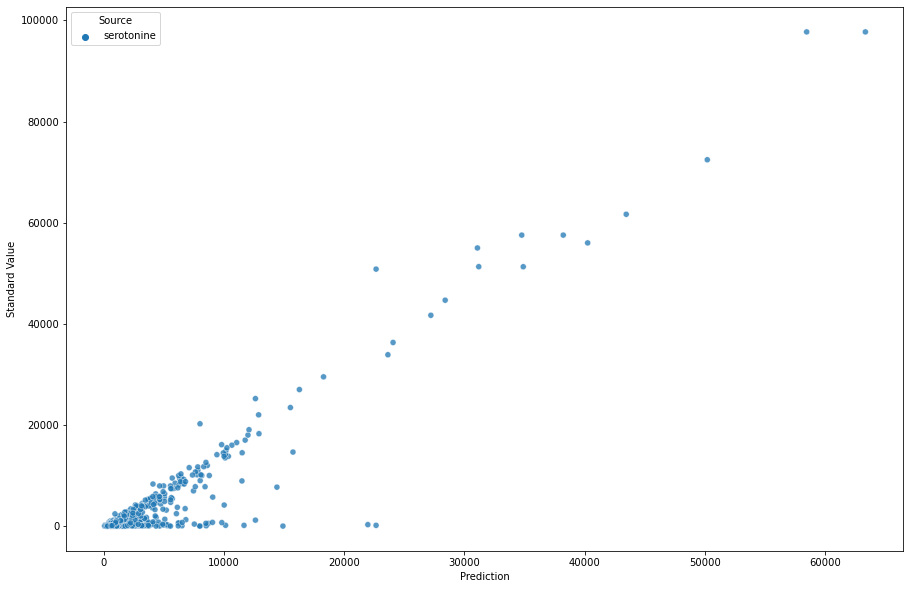

In [58]:
fig, ax = pyplot.subplots(figsize=(15,10))
p=seaborn.scatterplot(x="Prediction",
                      y="Standard Value",
                      data=res_rf,
                      hue="Source",
                      legend="brief",
                      ax=ax,
                      alpha=0.75
                     )

Better, but still not perfect...

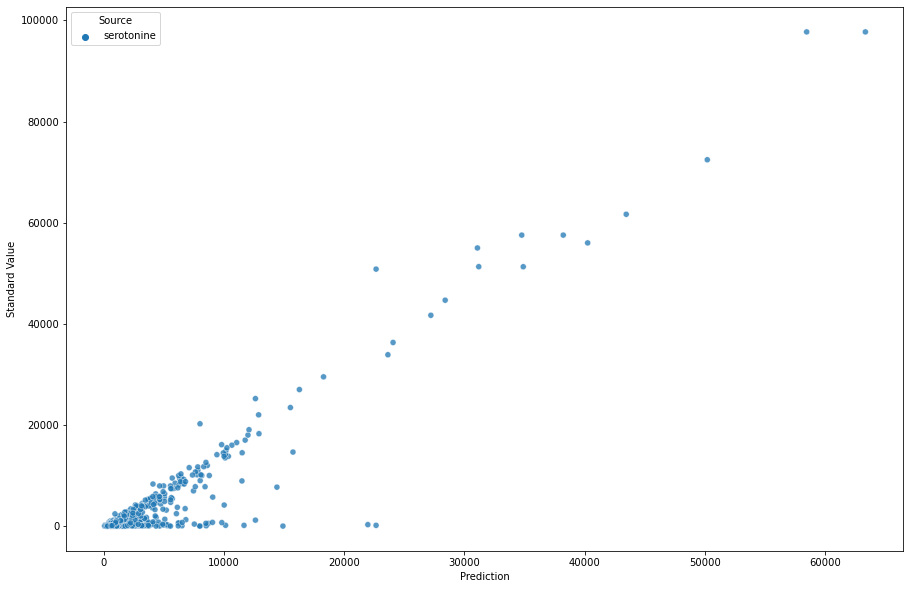

In [59]:
fig, ax = pyplot.subplots(figsize=(15,10))
p=seaborn.scatterplot(x="Prediction",
                      y="Standard Value",
                      data=res_rf[res_rf["Standard Value"]<mx/1000][res_rf["Prediction"]<1e6],
                      hue="Source",
                      legend="brief",
                      ax=ax,
                      alpha=0.75
                     )

## pCHEMBL

### SVR

In [60]:
svr_p = svm.SVR()
svr_p.fit(df_serotonine[df_serotonine["pChEMBL Value"]>0][(f"MQN_{x}" for x in range(1, 43))], df[df["pChEMBL Value"]>0]["pChEMBL Value"])

SVR()

In [61]:
res_svr_p = get_results(svr_p, df_serotonine, (f"MQN_{x}" for x in range(1, 43)), "pChEMBL Value")

Average error whole set: 0.7274661612781311
Average error serotonine: 0.7274661612781311


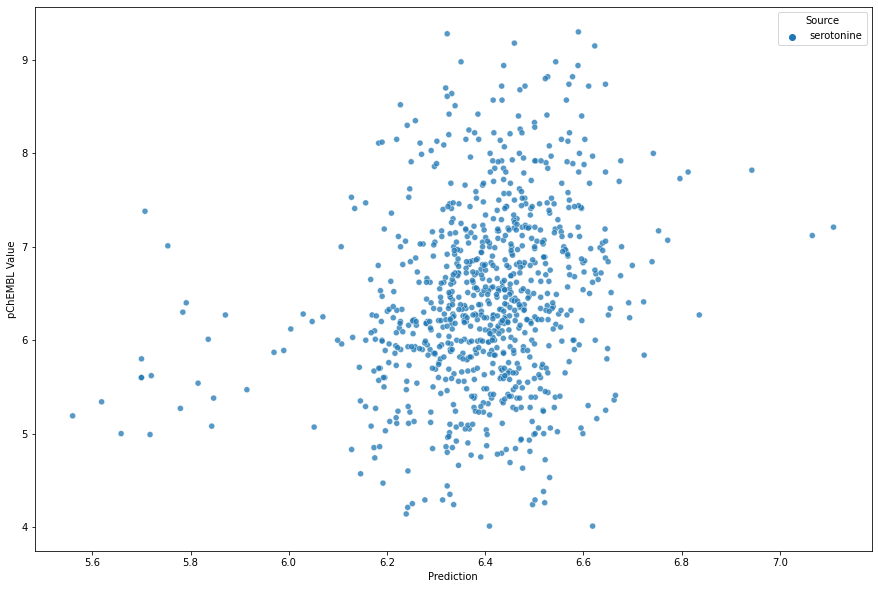

In [62]:
fig, ax = pyplot.subplots(figsize=(15,10))
p=seaborn.scatterplot(x="Prediction",
                      y="pChEMBL Value",
                      data=res_svr_p[res_svr_p["pChEMBL Value"]>0],
                      hue="Source",
                      legend="brief",
                      ax=ax,
                      alpha=0.75
                     )

### SVR with PCA

In [63]:
norm = preprocessing.normalize(df[(f"MQN_{x}" for x in range(1, 43))])
pca = decomposition.PCA(n_components=42)
pca.fit(norm)
df_serotonine = df_serotonine.join(pd.DataFrame(pca.transform(norm), columns=[f"nPCA_{x}" for x in range(1, 43)]))

In [64]:
svr_np = svm.SVR()
svr_np.fit(df_serotonine[(f"nPCA_{x}" for x in range(1, 43))], df_serotonine["pChEMBL Value"])

SVR()

In [65]:
res_svr_np = res = get_results(svr_np, df_serotonine, (f"nPCA_{x}" for x in range(1, 43)), "pChEMBL Value")

Average error whole set: 0.6525261745185768
Average error serotonine: 0.6525261745185768


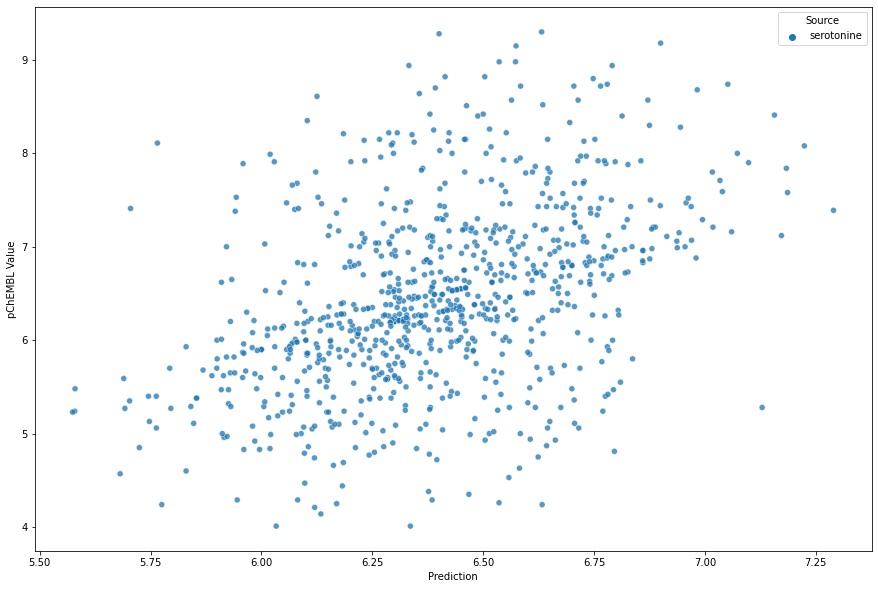

In [66]:
fig, ax = pyplot.subplots(figsize=(15,10))
p=seaborn.scatterplot(x="Prediction",
                      y="pChEMBL Value",
                      data=res_svr_np[res_svr_np["pChEMBL Value"]>0],
                      hue="Source",
                      legend="brief",
                      ax=ax,
                      alpha=0.75
                     )

### SVR with other kernel

In [67]:
svr_poly = svm.SVR(kernel='poly')
svr_poly.fit(df_serotonine[(f"nPCA_{x}" for x in range(1, 43))], df_serotonine["pChEMBL Value"])

SVR(kernel='poly')

In [68]:
res_poly = get_results(svr_poly, df_serotonine, (f"nPCA_{x}" for x in range(1, 43)), "pChEMBL Value")

Average error whole set: 0.6542919278444674
Average error serotonine: 0.6542919278444674


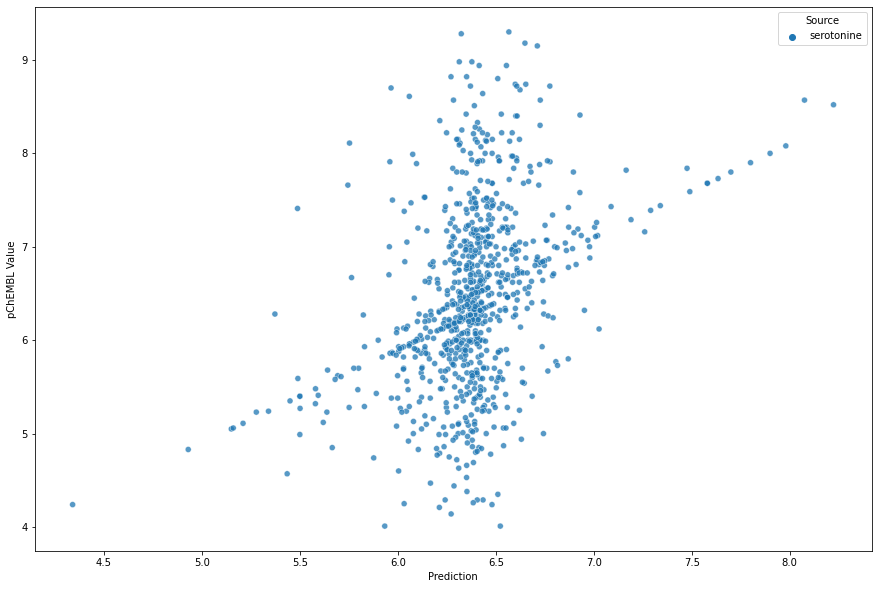

In [69]:
fig, ax = pyplot.subplots(figsize=(15,10))
p=seaborn.scatterplot(x="Prediction",
                      y="pChEMBL Value",
                      data=res_poly[res_poly["pChEMBL Value"]>0],
                      hue="Source",
                      legend="brief",
                      ax=ax,
                      alpha=0.75
                     )

There seem to be some data points with a nice linear relationship, but others break it :(

### Random Forest

In [70]:
rf_p = ensemble.RandomForestRegressor()
rf_p.fit(df_serotonine[(f"MQN_{x}" for x in range(1, 43))], df_serotonine["pChEMBL Value"])

RandomForestRegressor()

In [71]:
res_rf_p = get_results(rf_p, df_serotonine, (f"MQN_{x}" for x in range(1, 43)), "pChEMBL Value")

Average error whole set: 0.3118733560481667
Average error serotonine: 0.3118733560481667


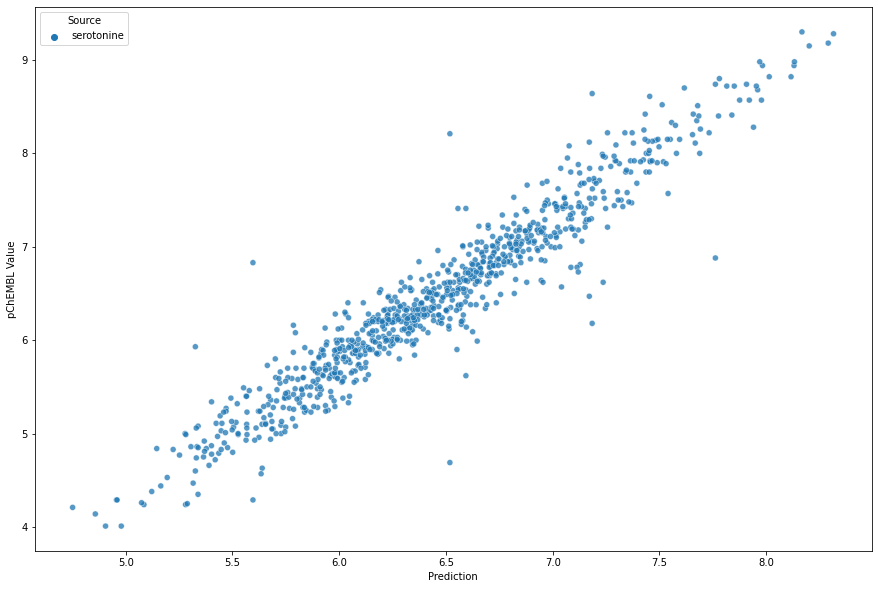

In [72]:
fig, ax = pyplot.subplots(figsize=(15,10))
p=seaborn.scatterplot(x="Prediction",
                      y="pChEMBL Value",
                      data=res_rf_p[res_rf_p["pChEMBL Value"]>0],
                      hue="Source",
                      legend="brief",
                      ax=ax,
                      alpha=0.75
                     )

## Train - Test division

Now let's take it seriously - let's test on holdout data.

In [113]:
trainset, testset = ms.train_test_split(df_serotonine)

In [114]:
trainset.reset_index(inplace=True)
testset.reset_index(inplace=True)

In [115]:
len(trainset), len(testset)

(652, 218)

Kind of a small dataset, but it will have to do.

### Random Forest

In [83]:
finaly_good_model = ensemble.RandomForestRegressor()
finaly_good_model.fit(trainset[(f"MQN_{x}" for x in range(1, 43))], trainset["pChEMBL Value"])

RandomForestRegressor()

In [84]:
train_results = get_results(finaly_good_model, trainset, (f"MQN_{x}" for x in range(1, 43)), "pChEMBL Value")

Average error whole set: 0.3089681722903887
Average error serotonine: 0.3089681722903887


In [85]:
test_results = get_results(finaly_good_model, testset, (f"MQN_{x}" for x in range(1, 43)), "pChEMBL Value")

Average error whole set: 0.7986494855832241
Average error serotonine: 0.7986494855832241


In [86]:
print("R^2: %0.2f" % finaly_good_model.score(testset[(f"MQN_{x}" for x in range(1, 43))], testset["pChEMBL Value"]))
print("R: %0.2f" % np.sqrt(finaly_good_model.score(testset[(f"MQN_{x}" for x in range(1, 43))], testset["pChEMBL Value"])))
print("MSE: %0.2f" %  mean_squared_error(test_results["Prediction"], test_results["pChEMBL Value"]))

R^2: -0.25
R: nan
MSE: 1.08


C:\ProgramFiles\Anaconda3\envs\cdd\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in sqrt
  


Whoa, this is weird. 

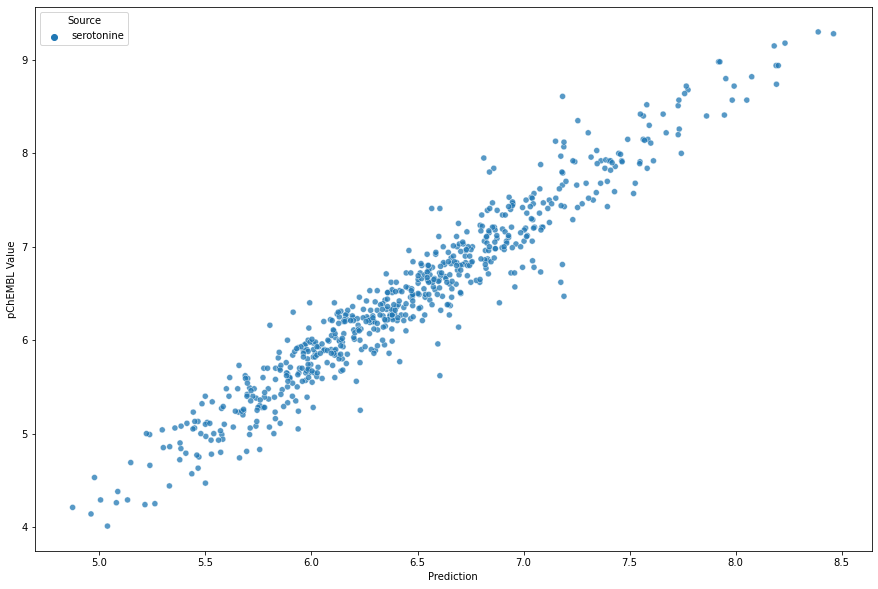

In [87]:
fig, ax = pyplot.subplots(figsize=(15,10))
p=seaborn.scatterplot(x="Prediction",
                      y="pChEMBL Value",
                      data=train_results,
                      hue="Source",
                      legend="brief",
                      ax=ax,
                      alpha=0.75
                     )

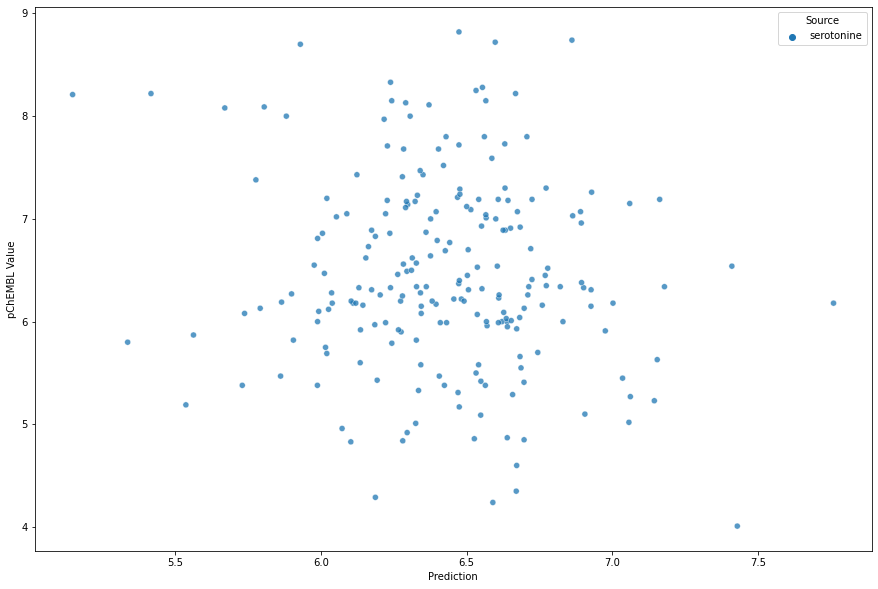

In [88]:
fig, ax = pyplot.subplots(figsize=(15,10))
p=seaborn.scatterplot(x="Prediction",
                      y="pChEMBL Value",
                      data=test_results,
                      hue="Source",
                      legend="brief",
                      ax=ax,
                      alpha=0.75
                     )

### Random Forest with PCA

In [89]:
rf_np = ensemble.RandomForestRegressor()
rf_np.fit(trainset[(f"nPCA_{x}" for x in range(1, 43))], trainset["pChEMBL Value"])

RandomForestRegressor()

In [90]:
train_results = get_results(rf_np, trainset, (f"nPCA_{x}" for x in range(1, 43)), "pChEMBL Value")

Average error whole set: 0.3003080859260885
Average error serotonine: 0.3003080859260885


In [91]:
test_results = get_results(rf_np, testset, (f"nPCA_{x}" for x in range(1, 43)), "pChEMBL Value")

Average error whole set: 0.74980874890782
Average error serotonine: 0.74980874890782


In [92]:
print("R^2: %0.2f" % rf_np.score(testset[(f"MQN_{x}" for x in range(1, 43))], testset["pChEMBL Value"]))
print("R: %0.2f" % np.sqrt(rf_np.score(testset[(f"MQN_{x}" for x in range(1, 43))], testset["pChEMBL Value"])))
print("MSE: %0.2f" %  mean_squared_error(test_results["Prediction"], test_results["pChEMBL Value"]))

R^2: -0.03
R: nan
MSE: 0.94


C:\ProgramFiles\Anaconda3\envs\cdd\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in sqrt
  


### k-NN

In [93]:
knn = neighbors.KNeighborsRegressor(5)
knn.fit(trainset[(f"MQN_{x}" for x in range(1, 43))], trainset["pChEMBL Value"])

KNeighborsRegressor()

In [94]:
train_results = get_results(knn, trainset, (f"MQN_{x}" for x in range(1, 43)), "pChEMBL Value")

Average error whole set: 0.714340490797546
Average error serotonine: 0.714340490797546


In [95]:
test_results = get_results(knn, testset, (f"MQN_{x}" for x in range(1, 43)), "pChEMBL Value")

Average error whole set: 0.8008899082568807
Average error serotonine: 0.8008899082568807


Ok, so k-NN is probably not the best choice, although it's not too bad.

### Gradient Boosting

In [96]:
grad = ensemble.GradientBoostingRegressor()
grad.fit(trainset[(f"MQN_{x}" for x in range(1, 43))], trainset["pChEMBL Value"])

GradientBoostingRegressor()

In [97]:
train_results = get_results(grad, trainset, (f"MQN_{x}" for x in range(1, 43)), "pChEMBL Value")

Average error whole set: 0.5857709264937754
Average error serotonine: 0.5857709264937754


In [98]:
test_results = get_results(grad, testset, (f"MQN_{x}" for x in range(1, 43)), "pChEMBL Value")

Average error whole set: 0.7962644254725377
Average error serotonine: 0.7962644254725377


In [99]:
print("R^2: %0.2f" % grad.score(testset[(f"MQN_{x}" for x in range(1, 43))], testset["pChEMBL Value"]))
print("R: %0.2f" % np.sqrt(grad.score(testset[(f"MQN_{x}" for x in range(1, 43))], testset["pChEMBL Value"])))
print("MSE: %0.2f" %  mean_squared_error(test_results["Prediction"], test_results["pChEMBL Value"]))

R^2: -0.21
R: nan
MSE: 1.04


C:\ProgramFiles\Anaconda3\envs\cdd\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in sqrt
  


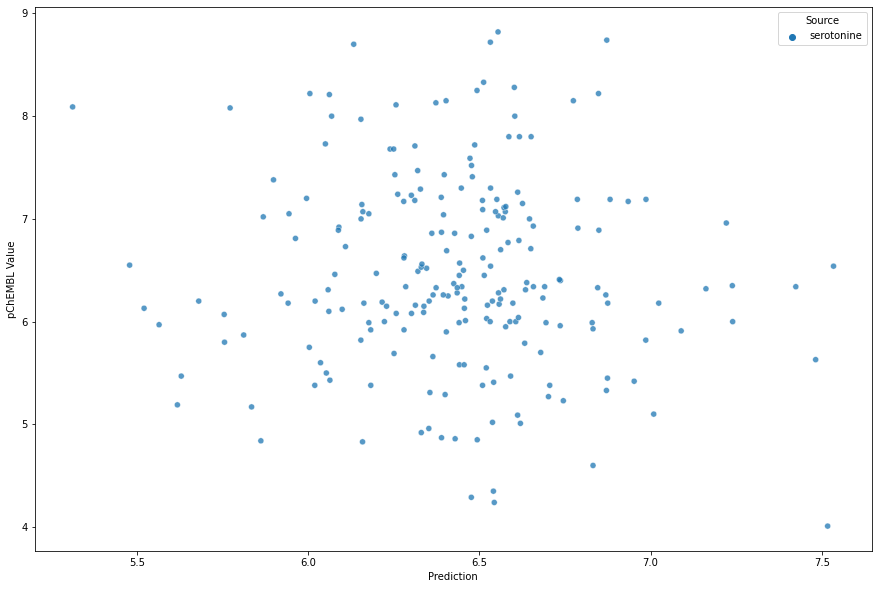

In [100]:
fig, ax = pyplot.subplots(figsize=(15,10))
p=seaborn.scatterplot(x="Prediction",
                      y="pChEMBL Value",
                      data=test_results,
                      hue="Source",
                      legend="brief",
                      ax=ax,
                      alpha=0.75
                     )

Let's try changing parameters.

In [101]:
grad_2 = ensemble.GradientBoostingRegressor(loss="lad")
grad_2.fit(trainset[(f"MQN_{x}" for x in range(1, 43))], trainset["pChEMBL Value"])

GradientBoostingRegressor(loss='lad')

In [102]:
train_results = get_results(grad_2, trainset, (f"MQN_{x}" for x in range(1, 43)), "pChEMBL Value")

Average error whole set: 0.6927237412382522
Average error serotonine: 0.6927237412382522


In [103]:
test_results = get_results(grad_2, testset, (f"MQN_{x}" for x in range(1, 43)), "pChEMBL Value")

Average error whole set: 0.7351619334914249
Average error serotonine: 0.7351619334914249


Similar...

In [104]:
grad_3 = ensemble.GradientBoostingRegressor(n_estimators=500)
grad_3.fit(trainset[(f"MQN_{x}" for x in range(1, 43))], trainset["pChEMBL Value"])

GradientBoostingRegressor(n_estimators=500)

In [105]:
train_results = get_results(grad_3, trainset, (f"MQN_{x}" for x in range(1, 43)), "pChEMBL Value")

Average error whole set: 0.30725361216967323
Average error serotonine: 0.30725361216967323


In [106]:
test_results = get_results(grad_3, testset, (f"MQN_{x}" for x in range(1, 43)), "pChEMBL Value")

Average error whole set: 0.8813335548554795
Average error serotonine: 0.8813335548554795


Not much better.

# Now let's train on Morgan fingerprints

In [130]:
X_train = trainset['fps'].to_list()
X_test = testset['fps'].to_list()

In [123]:
rf_fps = ensemble.RandomForestRegressor()
rf_fps.fit(X, trainset["pChEMBL Value"])

RandomForestRegressor()

In [167]:
def get_results_w_fps(model, test_data, test_set, predicted_value):
    res = pd.DataFrame(model.predict(test_data)).join(test_set[[predicted_value, "source"]])
    res.columns = ["Prediction", predicted_value, "Source"]
    print(f"""Average error whole set: {(res["Prediction"]-res[predicted_value]).abs().mean()}""")
#Average error serotonine: {(res[res["Source"]=="serotonine"]["Prediction"]-res[res["Source"]=="serotonine"][predicted_value]).abs().mean()}""")
    return res

In [168]:
train_results = get_results_w_fps(rf_fps, X_train, trainset, "pChEMBL Value")

Average error whole set: 0.18315063729428419


In [169]:
test_results = get_results_w_fps(rf_fps, X_test, testset, "pChEMBL Value")

Average error whole set: 0.5049964365807486


In [141]:
print("R^2: %0.2f" % rf_fps.score(X_test, testset["pChEMBL Value"]))
print("R: %0.2f" % np.sqrt(rf_fps.score(X_test, testset["pChEMBL Value"])))
print("MSE: %0.2f" %  mean_squared_error(test_results["Prediction"], test_results["pChEMBL Value"]))

R^2: 0.49
R: 0.70
MSE: 0.50


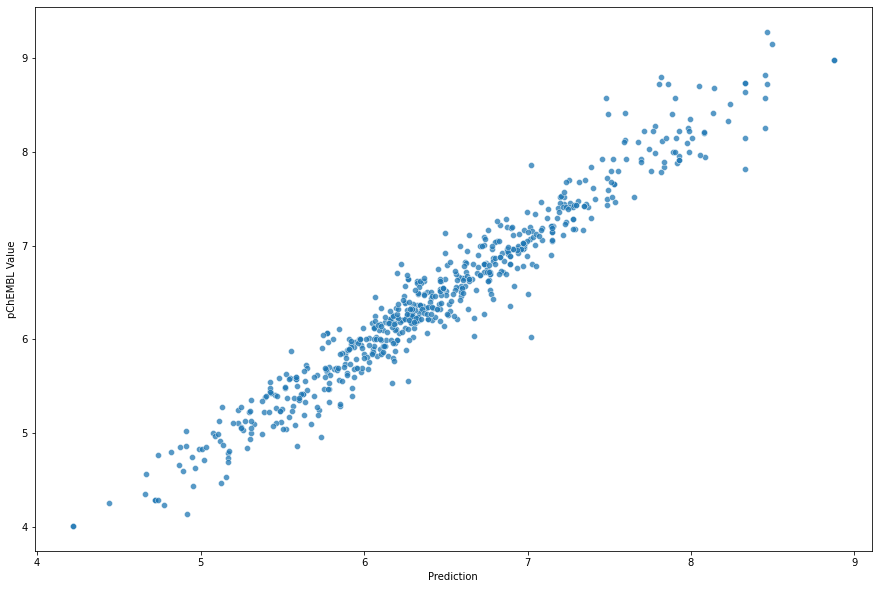

In [142]:
fig, ax = pyplot.subplots(figsize=(15,10))
p=seaborn.scatterplot(x="Prediction",
                      y="pChEMBL Value",
                      data=train_results,
                      legend="brief",
                      ax=ax,
                      alpha=0.75
                     )

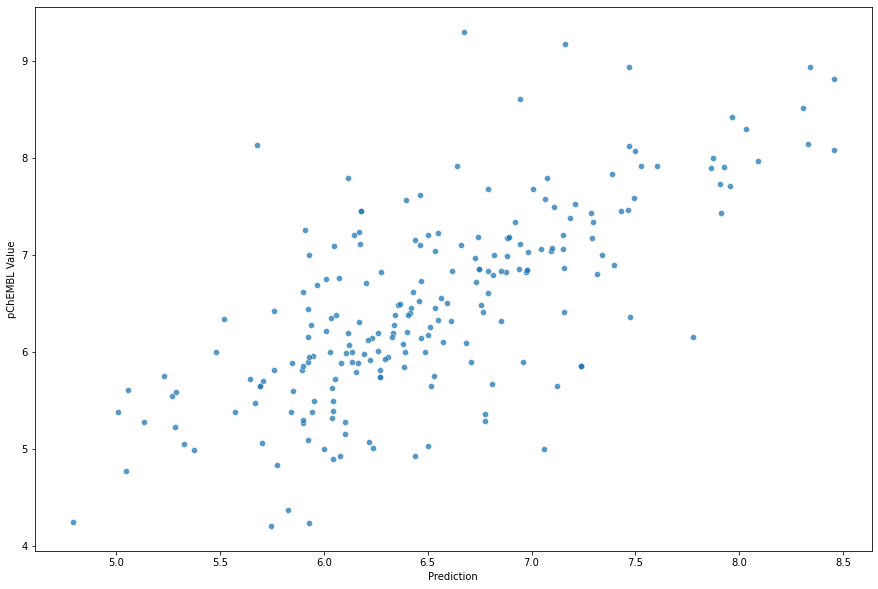

In [143]:
fig, ax = pyplot.subplots(figsize=(15,10))
p=seaborn.scatterplot(x="Prediction",
                      y="pChEMBL Value",
                      data=test_results,
                      legend="brief",
                      ax=ax,
                      alpha=0.75
                     )

This is actually much better than with MQNs.

Now for some more models:

## SVM

In [144]:
svr_fps = svm.SVR()
svr_fps.fit(X, trainset["pChEMBL Value"])

SVR()

In [170]:
train_results = get_results_w_fps(svr_fps, X_train, trainset, "pChEMBL Value")

Average error whole set: 0.2677853071517172


In [171]:
test_results = get_results_w_fps(svr_fps, X_test, testset, "pChEMBL Value")

Average error whole set: 0.5483857338873224


In [147]:
print("R^2: %0.2f" % svr_fps.score(X_test, testset["pChEMBL Value"]))
print("R: %0.2f" % np.sqrt(svr_fps.score(X_test, testset["pChEMBL Value"])))
print("MSE: %0.2f" %  mean_squared_error(test_results["Prediction"], test_results["pChEMBL Value"]))

R^2: 0.43
R: 0.66
MSE: 0.55


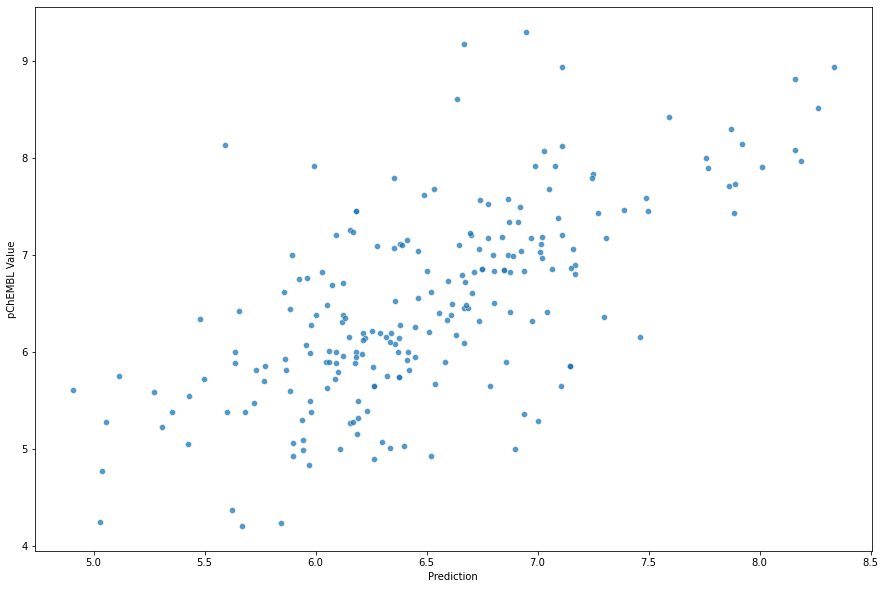

In [148]:
fig, ax = pyplot.subplots(figsize=(15,10))
p=seaborn.scatterplot(x="Prediction",
                      y="pChEMBL Value",
                      data=test_results,
                      legend="brief",
                      ax=ax,
                      alpha=0.75
                     )

## Gradient boosting

In [152]:
grad_fps = ensemble.GradientBoostingRegressor()
grad_fps.fit(X, trainset["pChEMBL Value"])

GradientBoostingRegressor()

In [172]:
train_results = get_results_w_fps(grad_fps, X_train, trainset, "pChEMBL Value")

Average error whole set: 0.39226253204977135


In [173]:
test_results = get_results_w_fps(grad_fps, X_test, testset, "pChEMBL Value")

Average error whole set: 0.6147710562926393


In [155]:
print("R^2: %0.2f" % grad_fps.score(X_test, testset["pChEMBL Value"]))
print("R: %0.2f" % np.sqrt(grad_fps.score(X_test, testset["pChEMBL Value"])))
print("MSE: %0.2f" %  mean_squared_error(test_results["Prediction"], test_results["pChEMBL Value"]))

R^2: 0.35
R: 0.59
MSE: 0.64


Once more with different parameters:

In [156]:
grad_fps_big = ensemble.GradientBoostingRegressor(n_estimators=400)
grad_fps_big.fit(X, trainset["pChEMBL Value"])

GradientBoostingRegressor(n_estimators=400)

In [174]:
train_results = get_results_w_fps(grad_fps_big, X_train, trainset, "pChEMBL Value")

Average error whole set: 0.21217727382804916


In [175]:
test_results = get_results_w_fps(grad_fps_big, X_test, testset, "pChEMBL Value")

Average error whole set: 0.5809062629431806


In [159]:
print("R^2: %0.2f" % grad_fps_big.score(X_test, testset["pChEMBL Value"]))
print("R: %0.2f" % np.sqrt(grad_fps_big.score(X_test, testset["pChEMBL Value"])))
print("MSE: %0.2f" %  mean_squared_error(test_results["Prediction"], test_results["pChEMBL Value"]))

R^2: 0.38
R: 0.61
MSE: 0.61


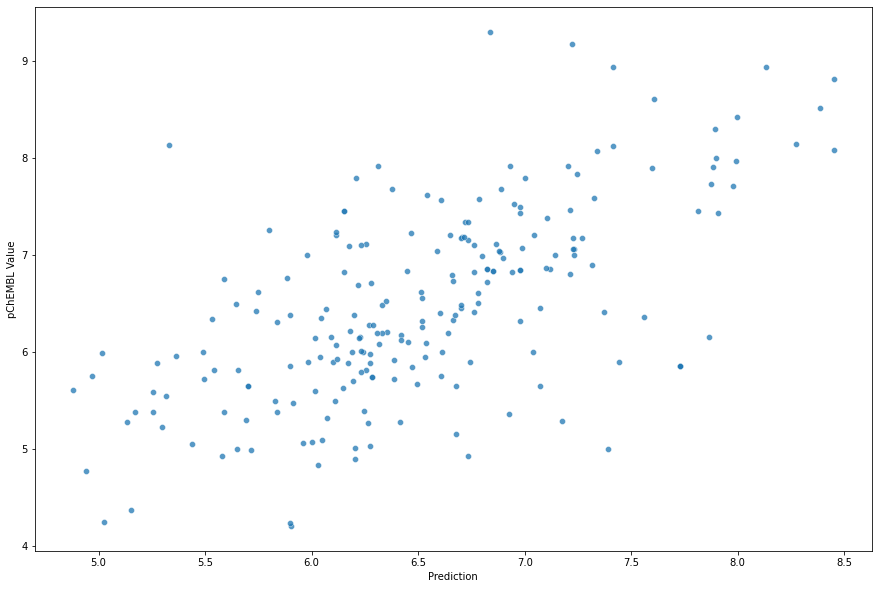

In [160]:
fig, ax = pyplot.subplots(figsize=(15,10))
p=seaborn.scatterplot(x="Prediction",
                      y="pChEMBL Value",
                      data=test_results,
                      legend="brief",
                      ax=ax,
                      alpha=0.75
                     )

Not that much better than before.

One last attempt:

In [162]:
rf_fps_big = ensemble.RandomForestRegressor(n_estimators=400)
rf_fps_big.fit(X, trainset["pChEMBL Value"])

RandomForestRegressor(n_estimators=400)

In [176]:
train_results = get_results_w_fps(rf_fps_big, X_train, trainset, "pChEMBL Value")

Average error whole set: 0.18235234034168246


In [177]:
test_results = get_results_w_fps(rf_fps_big, X_test, testset, "pChEMBL Value")

Average error whole set: 0.5079155669324311


In [165]:
print("R^2: %0.2f" % rf_fps_big.score(X_test, testset["pChEMBL Value"]))
print("R: %0.2f" % np.sqrt(rf_fps_big.score(X_test, testset["pChEMBL Value"])))
print("MSE: %0.2f" %  mean_squared_error(test_results["Prediction"], test_results["pChEMBL Value"]))

R^2: 0.49
R: 0.70
MSE: 0.50


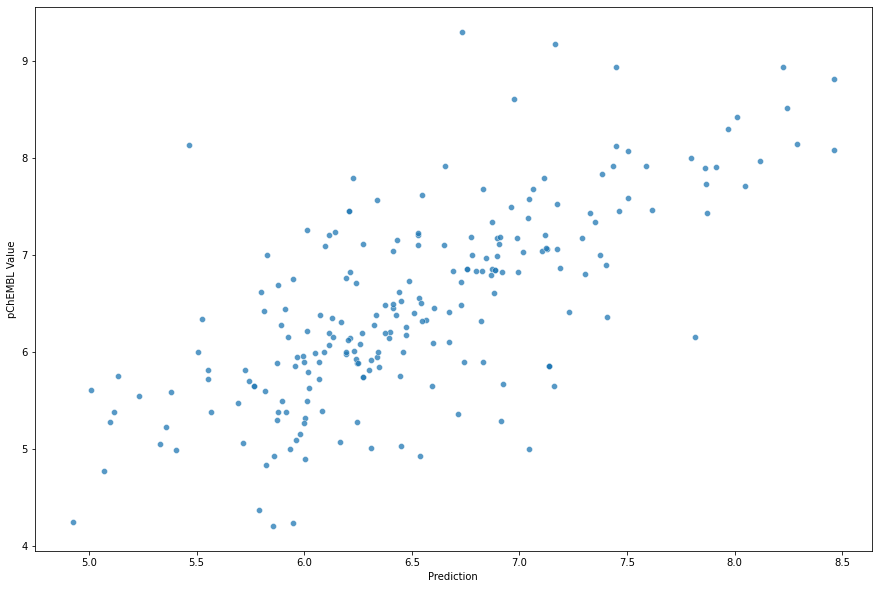

In [166]:
fig, ax = pyplot.subplots(figsize=(15,10))
p=seaborn.scatterplot(x="Prediction",
                      y="pChEMBL Value",
                      data=test_results,
                      legend="brief",
                      ax=ax,
                      alpha=0.75
                     )

# Outcome

It seems that the very best model is a random forest with 100 trees trained on Morgan fingerprints with a test error of 0.505 and R^2 0.49.